In [11]:
import sys
import os
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.style.use('JFM')

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.common import *

dtheta_s7 = 0.018*0.1338770483624053/0.180376365676346

# Make linear fit
def linear_fit(time,dtheta,tstart,tend,verbose=True):
    ts = which_tID(time,tstart)
    te = which_tID(time,tend)+1
    t_fit = time[ts:te]
    dat_fit = dtheta[ts:te]
    growth_rate,shift = np.polyfit(t_fit, dat_fit, 1) #linear fit
    if verbose:
        #print("Fitting between times {}-{} (steps {}-{})".format(time[ts],time[te],ts,te))
        print("dtheta growth: {} - {}".format(dtheta[ts],dtheta[te]))
        print("dtheta growth rate: {}".format(growth_rate))
    return t_fit,growth_rate,shift

/lus/theta-fs0/projects/HighMachTurbulence/ShearLayerData/temporal/Mc02/rr1/1024x1448x512/
Final dtheta = 4.52850914959
Final rate = 0.811500913019


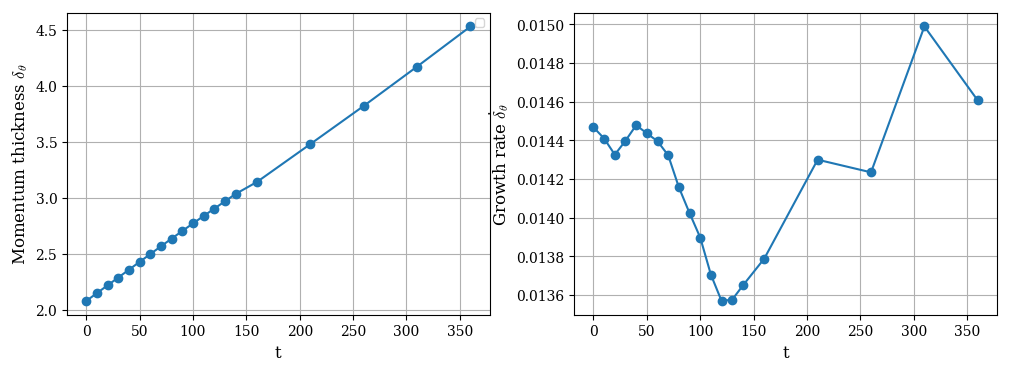

In [2]:

def plot_growth(directory,tstart=None,savename=''):
    inp = nml.inputs(directory,verbose=False)
    time,dtheta,rate = growth_rates(directory+'/shearlayer_')

    fig, axarr = plt.subplots(1,2, figsize=(12,4), dpi=100) 
    axarr[0].plot(time,dtheta,'-o'); axarr[0].grid(True);
    axarr[0].grid(True)
    axarr[0].set_ylabel(r'Momentum thickness $\delta_\theta$')
    axarr[0].set_xlabel('t')

    # Linear fit
    if tstart is not None:
        t_fit,growth_rate,shift = linear_fit(time,dtheta,tstart=tstart,tend=time[-1],verbose=False)
        axarr[0].plot(t_fit,t_fit*growth_rate+shift,'k--',label=r'$\dot{\delta}_{\theta}$=%0.4f'%(growth_rate/inp.du))
    axarr[0].legend()
    
    axarr[1].plot(time,rate,'-o')
    axarr[1].set_ylabel(r'Growth rate $\dot{\delta}_\theta$')
    axarr[1].set_xlabel('t')
    axarr[1].grid(True)

    # fig.suptitle('Time: {}'.format(np.around(reader.time,-1)),size=fs,y=0.95)
    if savename:
        fig.savefig(savename, dpi=200,bbox_inches='tight')
        plt.close(fig)
        print "Saved plot to ",savename
    else: 
        print(directory)
        print('Final dtheta = {}'.format(dtheta[-1]))
        print('Final rate = {}'.format(np.mean(rate[-1::])/0.018))
        plt.show()
    
directory = '/lus/theta-fs0/projects/HighMachTurbulence/ShearLayerData/temporal/Mc02/rr1/1024x1448x512/'
plot_growth(directory,tstart=None)#,savename=directory+'/img/dtheta.png')

In [9]:
du = { #U_L/dU
0.2:[0.320878628692,0.014354985748],
0.4:[0.28759238955,0.0173941871764],
0.8:[0.179652184681,0.012733736384],
1.2:[0.152164204092,0.0106738755021],
1.6:[0.144804252876,0.00974592070867],
2.0:[0.142805206381,0.0110827643436],
}

Text(0,0.5,'Growth rate $\\dot{\\delta}_\\theta$')

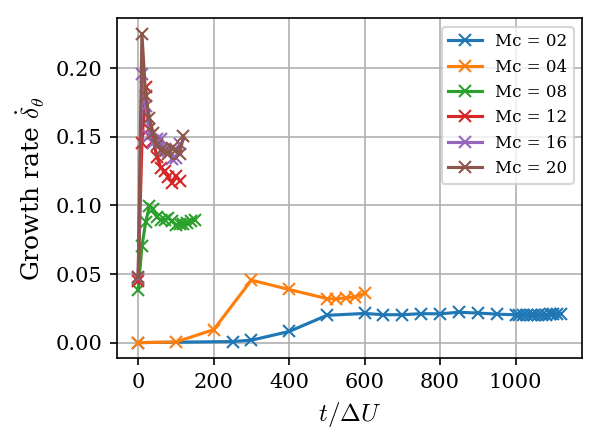

In [10]:
s = '1'
if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']

scaling = 1
    
plt.figure(figsize=(4,3),dpi=150)
for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    inp = nml.inputs(directory,verbose=False)
    
    if Mc=='02': ist=0;ien=-1
    elif Mc=='04': ist=0;ien=13-3
    else: ist=0; ien=-1
    
    time,dtheta,rate = growth_rates(directory+'/shearlayer_')
    idx = np.argsort(time)
    time = time[idx]
    rate = rate[idx]
    if scaling: 
        scale = du[inp.Mc][0]/inp.du
        rate /= scale
    plt.plot(time[ist:ien],rate[ist:ien],'-x',label='Mc = %s'%Mc)
plt.legend()
plt.grid(True)
plt.xlabel(r'$t/\Delta U$')
plt.ylabel(r'Growth rate $\dot{\delta}_\theta$')

In [6]:
def plotter(directory,tstart=0,tend=None,linetype='solid'):
    inp = nml.inputs(directory,verbose=False)
    time,dtheta,domega = growth_rates(directory+'shearlayer_')
    
    # self similar time:
    istart = np.argmin(abs(tstart-time))
    if tend==None: iend = np.size(time)-1
    else:  iend = np.argmin(abs(tend-time))
    idx = np.array([istart,iend])
    
    time *= inp.du
    time -= time[0]
    dtheta -= dtheta[0]-1.
    t_fit,growth_rate,shift = linear_fit(time,dtheta,tstart=tstart,tend=max(time),verbose=False)
    plt.plot(time,dtheta,'k',linestyle=linetype,label='$M_c$ = {}'.format(inp.Mc))
#     plt.plot(t_fit,t_fit*growth_rate+shift,'k--')
    print([istart,iend])
    plt.plot(time[idx],dtheta[idx],'k_',markersize=8)
    return growth_rate

[5, 18]
[5, 15]
[5, 16]
[4, 12]
[4, 10]
[4, 10]


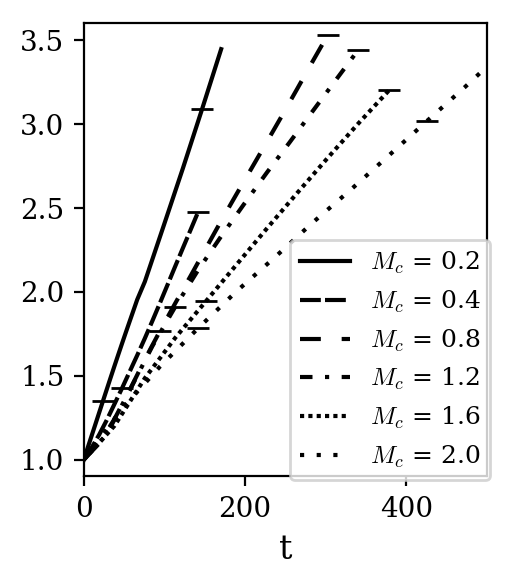

In [35]:
#Do for multiple Mc
fig = plt.figure(figsize=(2.6,3), dpi=200) 

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/1024x1448x512/'
directory='/lus/theta-fs0/projects/HighMachTurbulence/ShearLayerData/temporal/Mc02/rr1/1024x1448x512/'
plotter(directory,tstart=50,tend=300,linetype='solid')
directory='/lus/theta-fs0/projects/HighMachTurbulence/ShearLayerData/temporal/Mc04/rr1/1024x1448x512/'
plotter(directory,tstart=50,linetype=(0,(5,1)))
directory='/home/kmatsuno/ShearLayerData/production/Mc08/rr1/1024x1448x512/'
plotter(directory,tstart=50,linetype=(0,(5,5)))
directory='/home/kmatsuno/ShearLayerData/production/Mc12/rr1/1024x1448x512/'
plotter(directory,tstart=40,tend=None,linetype=(0,(3,3,1,3)))
directory='/home/kmatsuno/ShearLayerData/production/Mc16/rr1/1024x1448x512/'
plotter(directory,tstart=40,tend=100,linetype=(0,(1,1)))
directory='/home/kmatsuno/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
plotter(directory,tstart=40,tend=100,linetype=(0,(1,3)))

plt.xlabel('t')
plt.xlim([0,500])
plt.ylim([0.9,3.6])
# plt.grid(True)
# plt.ylabel(r'$\delta_{\theta}(t)$')
plt.legend(fontsize=9,bbox_to_anchor=(0.48, 0.55))

0.014347306098882994
0.006213285018745358
0.006504478730976654


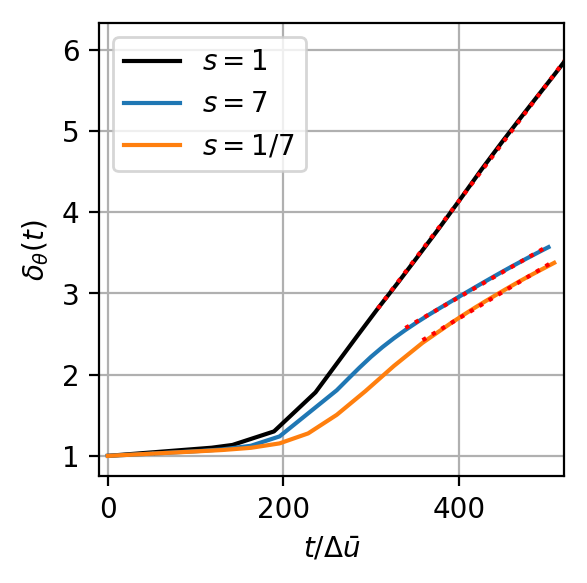

In [22]:
#Do for multiple s
def normalize(inp,time,dtheta):
    time *= inp.du
    dtheta /= dtheta[0]
    i = np.argsort(time)
    return time[i],dtheta[i]

fig = plt.figure(figsize=(3,3), dpi=200) 
Mc = '02'
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr1/1024x1448x512/'%Mc
inp = nml.inputs(directory,verbose=False)
time,dtheta,domega = growth_rates(directory+'shearlayer_')
time,dtheta = normalize(inp,time,dtheta)
t_fit,growth_rate,shift = linear_fit(time,dtheta,tstart=300,tend=max(time),verbose=False)
plt.plot(time,dtheta,'k-',label='$s=1$')
plt.plot(t_fit,t_fit*growth_rate+shift,'r:')
print(growth_rate)

directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr7/1024x1448x512/'%Mc
inp = nml.inputs(directory,verbose=False)
time,dtheta,domega = growth_rates(directory+'shearlayer_')
time,dtheta = normalize(inp,time,dtheta)
t_fit,growth_rate,shift = linear_fit(time,dtheta,tstart=340,tend=max(time),verbose=False)
plt.plot(time,dtheta,'-',label='$s=7$')
plt.plot(t_fit,t_fit*growth_rate+shift,'r:')
print(growth_rate)

directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr_7/1024x1448x512/'%Mc
inp = nml.inputs(directory,verbose=False)
time,dtheta,domega = growth_rates(directory+'shearlayer_')
time,dtheta = normalize(inp,time,dtheta)
t_fit,growth_rate,shift = linear_fit(time,dtheta,tstart=360,tend=max(time),verbose=False)
plt.plot(time,dtheta,'-',label='$s=1/7$')
plt.plot(t_fit,t_fit*growth_rate+shift,'r:')
print(growth_rate)

plt.xlim([-10,520])
plt.xlabel(r'$t/\Delta \bar{u}$')
plt.grid(True)
plt.ylabel(r'$\delta_{\theta}(t)$')
plt.legend()

[1, 13]
[3, 9]
[3, 8]


/gpfs/mira-home/kmatsuno/floatpy_env/lib/python2.7/site-packages/ipykernel_launcher.py:28: RankWarning: Polyfit may be poorly conditioned


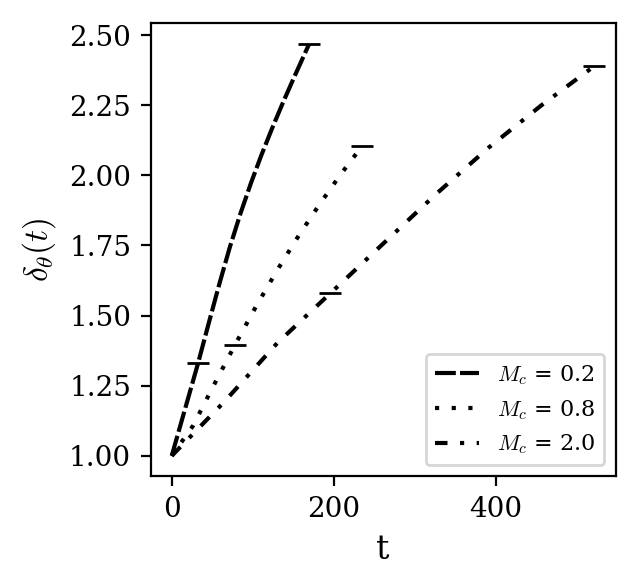

In [16]:
fig = plt.figure(figsize=(3,3), dpi=200) 

directory='/home/kmatsuno/ShearLayerData/production/Mc02/rr7/1024x1448x512/'
plotter(directory,tstart=400,linetype=(0,(5,1)))
directory='/home/kmatsuno/ShearLayerData/production/Mc08/rr7/1024x1448x512/'
plotter(directory,tstart=30,linetype=(0,(1,3)))
directory='/home/kmatsuno/ShearLayerData/production/Mc20/rr_7/1024x1448x512/'
plotter(directory,tstart=30,linetype=(0,(3,3,1,3)))

plt.xlabel('t')
#plt.xlim([0,2000])
#plt.ylim([0,18])
# plt.grid(True)
plt.ylabel(r'$\delta_{\theta}(t)$')
plt.legend()#bbox_to_anchor=(1, 0.75))

0.004315023926306891
0.006071113827678665
0.010197041824512055


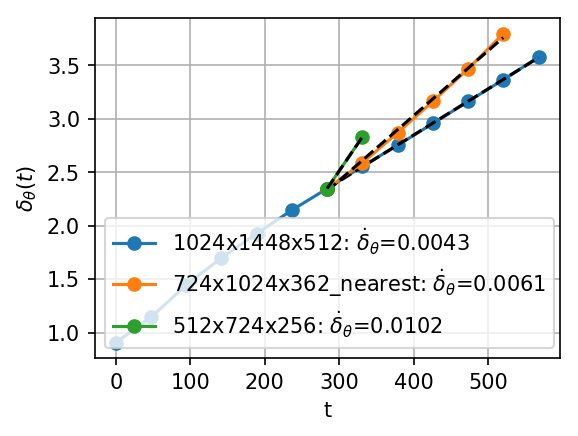

In [3]:
# Compare grid res
plt.figure(figsize=(4,3),dpi=150)

# Mc = '02'; ts = 250;
Mc = '20'; ts = 270;

gridres='1024x1448x512'
# ts = 250
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr1/%s/'%(Mc,gridres)
inp = nml.inputs(directory,verbose=False)
time,dtheta,domega = growth_rates(directory+'shearlayer_')
time *= inp.du
t_fit,growth_rate,shift = linear_fit(time,dtheta,tstart=ts,tend=max(time),verbose=False)
plt.plot(time,dtheta,'-o',label=r'%s: $\dot{\delta}_\theta$=%0.4f'%(gridres,growth_rate))
plt.plot(t_fit,t_fit*growth_rate+shift,'k--')
print(growth_rate)

time_fine = time
dtheta_fine = dtheta

gridres='724x1024x362_nearest'
# ts = 250
shift0 = dtheta_fine[np.argmin(abs(ts-time_fine))]
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr1/%s/'%(Mc,gridres)
inp = nml.inputs(directory,verbose=False)
time,dtheta,domega = growth_rates(directory+'shearlayer_')
time *= inp.du
t_fit,growth_rate,shift = linear_fit(time,dtheta,tstart=ts,tend=max(time),verbose=False)
plt.plot(time,dtheta-(dtheta[0]-shift0),'-o',label=r'%s: $\dot{\delta}_\theta$=%0.4f'%(gridres,growth_rate))
plt.plot(t_fit,t_fit*growth_rate+shift-(dtheta[0]-shift0),'k--')
print(growth_rate)
    

gridres='512x724x256'
# ts = 250
shift0 = dtheta_fine[np.argmin(abs(ts-time_fine))]
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr1/%s/'%(Mc,gridres)
inp = nml.inputs(directory,verbose=False)
time,dtheta,domega = growth_rates(directory+'shearlayer_')
time *= inp.du
t_fit,growth_rate,shift = linear_fit(time,dtheta,tstart=ts,tend=max(time),verbose=False)
plt.plot(time,dtheta-(dtheta[0]-shift0),'-o',label=r'%s: $\dot{\delta}_\theta$=%0.4f'%(gridres,growth_rate))
plt.plot(t_fit,t_fit*growth_rate+shift-(dtheta[0]-shift0),'k--')
print(growth_rate)
        
plt.xlabel('t')
plt.grid(True)
plt.ylabel(r'$\delta_{\theta}(t)$')
plt.legend()
# plt.savefig('/home/kmatsuno/ShearLayer_img/gridres_Mc%s/dtheta.png'%Mc)